In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.dataloader import singleCET_dataset
from cryoS2Sdrop.model import Denoising_UNet

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchinfo import summary

import os
from torch.utils.data import Dataset, DataLoader

PARENT_PATH = setup.PARENT_PATH

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_dummy.mrc')

p = 0.3
vol_scale_factor = 4
subtomo_length = 96

my_dataset = singleCET_dataset(cet_path, subtomo_length=subtomo_length, p=p, volumetric_scale_factor=vol_scale_factor)

In [6]:
def collate_fn(batch):
    bernoulli_subtomo = torch.stack([b[0] for b in batch], axis=0).flatten(0, 1)
    target = torch.stack([b[0] for b in batch], axis=0).flatten(0, 1)
    bernoulli_mask = torch.stack([b[0] for b in batch], axis=0).flatten(0, 1)
    
    return bernoulli_subtomo, target, bernoulli_mask

In [7]:
batch_size = 2
dloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, collate_fn=collate_fn)

# Model

In [8]:
for batch in dloader:
    subtomo, target, mask = batch
    print(subtomo.shape)
    break

torch.Size([12, 1, 96, 96, 96])


In [21]:
n_features = 48
model = Denoising_UNet(None, 0, n_features, p)

In [22]:
96/32

3.0

In [24]:
model(subtomo).shape

torch.Size([12, 1, 96, 96, 96])

In [25]:
summary(model, (batch_size, 1, subtomo_length, subtomo_length, subtomo_length), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Denoising_UNet                           [2, 1, 96, 96, 96]        --
├─PartialConv3d: 1-1                     [2, 48, 96, 96, 96]       1,344
├─Sequential: 1-2                        [2, 48, 48, 48, 48]       --
│    └─PartialConv3d: 2-1                [2, 48, 96, 96, 96]       62,256
│    └─LeakyReLU: 2-2                    [2, 48, 96, 96, 96]       --
│    └─MaxPool3d: 2-3                    [2, 48, 48, 48, 48]       --
├─Sequential: 1-3                        [2, 48, 24, 24, 24]       --
│    └─PartialConv3d: 2-4                [2, 48, 48, 48, 48]       62,256
│    └─LeakyReLU: 2-5                    [2, 48, 48, 48, 48]       --
│    └─MaxPool3d: 2-6                    [2, 48, 24, 24, 24]       --
├─Sequential: 1-4                        [2, 48, 12, 12, 12]       --
│    └─PartialConv3d: 2-7                [2, 48, 24, 24, 24]       62,256
│    └─LeakyReLU: 2-8                    [2, 48, 24, 24, 24]       --


# Loss function

In [11]:
pred = (1-mask)*model(subtomo)
pred.shape

torch.Size([2, 1, 96, 96, 96])

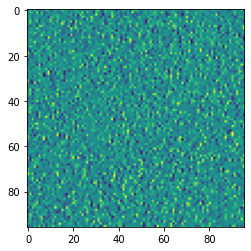

In [13]:
plt.imshow((subtomo+pred)[0][0][0].detach().numpy())

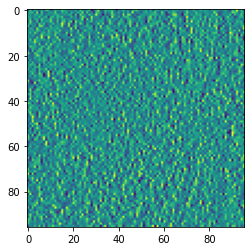

In [16]:
plt.imshow((subtomo+target)[0][0][0].detach().numpy())

In [14]:
from cryoS2Sdrop.losses import self2self_L2Loss, TotalVariation
# loss = self2self_L2Loss()
loss = TotalVariation()

In [13]:
loss(pred, target)

tensor(504.5622, grad_fn=<MeanBackward1>)

In [17]:
loss(subtomo+pred)

tensor([2315959.0000, 2294000.2500], grad_fn=<AddBackward0>)